Este cuadernillo contiene todo el código empleado para realizar la parte de nuestro TFM relativa al análisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalación de subprogramas y librerías
- Preprocesamiento de los datos
- Obtención y análisis de características de los datos

## Instalación de subprogramas y librerías

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import isodate #para manejar formato de duración ISO 8601
import re #para manejar expresiones regulares
from textblob import TextBlob

## Preprocesamiento de datos

In [22]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("videos_virales_final_cleaned.csv", low_memory=False)

In [23]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [24]:
#Debemos eliminar las filas con video_id nulo, ya que esa será la variable principal para la identificación de los vídeos.
#Según los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [25]:
#A continuación trataremos el resto de valores NaN.
#Para columnas alfanuméricas (string), cambiar por ""
#Para columnas numéricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [26]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [27]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada vídeo. Es decir, deberá tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtención y análisis de características

In [28]:
df = pd.read_csv("ytvg_unique.csv")

In [29]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'thumbnail_url_hq',
       'thumbnail_faces_count', 'title_length', 'title_word_count',
       'title_has_exclamation', 'title_has_question', 'title_sentiment',
       'title_has_keywords', 'title_uppercase_ratio', 'description_length',
       'description_sentiment', 'has_external_links', 'tag_count',
       'video_duration_sec', 'published_at', 'hour_of_day', 'day_of_week',
       'is_weekend', 'is_peak_hour', 'thumbnail_text_count',
       'thumbnail

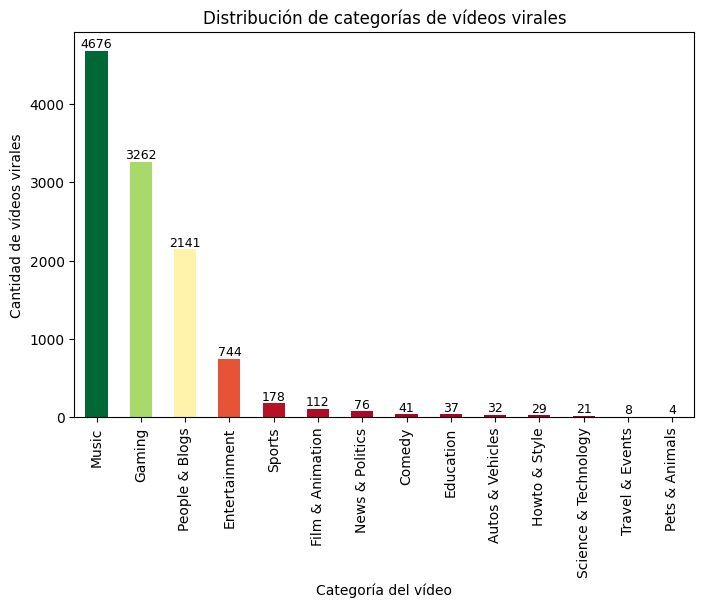

In [30]:
#Análisis de categorías
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de categorías de vídeos virales")
plt.xlabel("Categoría del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [31]:
#Análisis de duración. Formato de la duración: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    11371.000000
mean      2746.164453
std       6241.279159
min          9.000000
25%        192.000000
50%        350.000000
75%       1520.000000
max      73561.000000
Name: video_duration_segs, dtype: float64

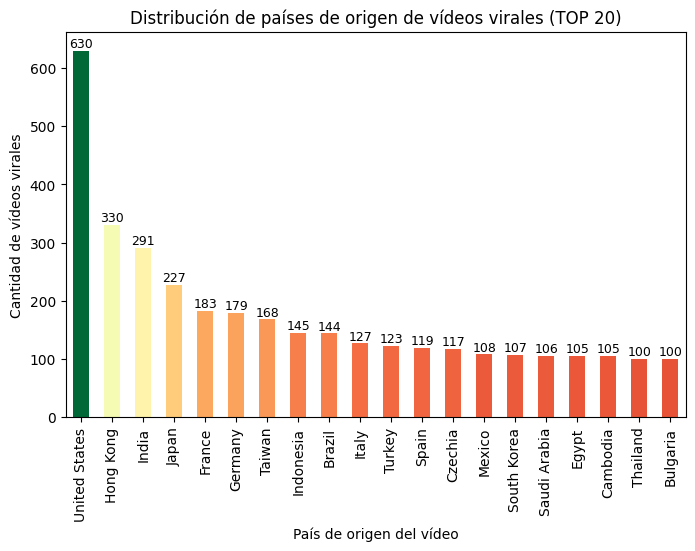

In [32]:
#País de origen de los vídeos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de países de origen de vídeos virales (TOP 20)")
plt.xlabel("País de origen del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [33]:
#Análisis de título (idioma, tamaño, emojis)

In [34]:
#Ratio visitas-suscriptores

## Preprocesamiento títulos - análisis de sentimientos

In [35]:
#funcion para extraer algunas características del título
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [36]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos

# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown')
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown')

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

In [37]:
df_preproc

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,is_peak_hour,thumbnail_text_count,thumbnail_colorfulness,is_viral,viral_score,views_per_second,likes_per_view,likes_per_sub,views_per_sub,video_duration_segs
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,True,0.0,11.933030,1,1137.770604,5407.291391,0.019319,2.175574,112.613061,301
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,True,0.0,66.092611,1,138.800536,669.881988,0.032637,0.314258,9.628694,160
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,False,0.0,22.409323,1,161.039149,787.114943,0.040640,0.292932,7.207936,173
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,False,0.0,25.591613,1,1220.609273,6058.800000,0.016517,0.292168,17.688636,39
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,True,0.0,18.225224,1,3159.208888,15765.357143,0.022758,0.279040,12.261263,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,QU_BbKjhqvU,2025-08-13T10:45:15Z,2025.08.13,Cambodia,ជួបគ្នាជាថ្មី? អត្ថប្រយោជន៍សត្វ Grow a garden 🪴,Hello everyone welcome to my channel I’m back ...,https://i.ytimg.com/vi/QU_BbKjhqvU/default.jpg,Gaming,NaN,PT7M27S,...,False,0.0,63.154100,0,1.035167,3.756696,0.144893,0.069694,0.480720,447
11367,uEL7YaEmIfI,2025-08-13T07:02:26Z,2025.08.13,Cambodia,🔴 LIVE | GTA5 ជួយដឹកជញ្ជូនអីវាន់ផ្ទះគេ ជួយមើលល...,PayWay Link : https://link.payway.com.kh/ABAPA...,https://i.ytimg.com/vi/uEL7YaEmIfI/default.jpg,Gaming,NaN,PT3H20M42S,...,False,0.0,40.258105,0,0.457851,0.225608,0.048197,0.038405,0.796541,12042
11368,uu0lAVK7S8k,2025-08-13T13:08:33Z,2025.08.13,Cambodia,KOLYOK មកហើយមកហើយ,បើស្រឡាញ់ចូលចិត្ត សូមចុច Subscribe និង like vi...,https://i.ytimg.com/vi/uu0lAVK7S8k/default_liv...,Gaming,"streamer live,game,minecraft,kolyok gaming,VTB...",PT1H52M41S,...,False,0.0,45.453721,0,0.174238,0.259539,0.100228,0.018505,0.184523,6761
11369,-esUfP27zzA,2025-08-13T11:01:56Z,2025.08.13,Cambodia,Welcome To My Live Guy i'm back !!!!!,----------------------------------------------...,https://i.ytimg.com/vi/-esUfP27zzA/default_liv...,People & Blogs,NaN,PT1H57M12S,...,False,0.0,45.604300,0,0.223584,0.445614,0.055502,0.013082,0.235621,7032


## Predicción de viralidad antes de publicar el vídeo

En este enfoque, el modelo solo utilizará información disponible antes de la publicación (título, descripción, categoría, duración, horario, etc.) para predecir si un vídeo será viral. Se eliminan todas las variables de interacción y métricas que solo se conocen tras la publicación.

In [39]:
# Definir X e y para clasificación binaria (viral/no viral)

if 'is_viral' in df:
    y_clf = df['is_viral']
    
X_clf = df_preproc_clf.copy()

from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

print('Shape X_train:', X_train_clf.shape)
print('Shape y_train:', y_train_clf.shape)
print('Proporción de clases en train:', y_train_clf.value_counts(normalize=True))

Shape X_train: (9096, 30)
Shape y_train: (9096,)
Proporción de clases en train: is_viral
1    0.709213
0    0.290787
Name: proportion, dtype: float64


In [40]:
# Entrenamiento y evaluación de modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Si no tienes xgboost instalado, descomenta la siguiente línea:
# !pip install xgboost
from xgboost import XGBClassifier

models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000)
}

results_clf = {}
for name, model in models_clf.items():
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    roc = roc_auc_score(y_test_clf, model.predict_proba(X_test_clf)[:,1])
    results_clf[name] = {'Accuracy': acc, 'F1': f1, 'ROC-AUC': roc}
    print(f"\n{name}")
    print(classification_report(y_test_clf, y_pred))

import pandas as pd
results_clf_df = pd.DataFrame(results_clf).T
print("\nResumen de resultados:")
print(results_clf_df.sort_values('ROC-AUC', ascending=False))


LogisticRegression
              precision    recall  f1-score   support

           0       0.65      0.43      0.52       662
           1       0.79      0.90      0.85      1613

    accuracy                           0.77      2275
   macro avg       0.72      0.67      0.68      2275
weighted avg       0.75      0.77      0.75      2275


RandomForest
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       662
           1       0.87      0.94      0.90      1613

    accuracy                           0.85      2275
   macro avg       0.84      0.79      0.81      2275
weighted avg       0.85      0.85      0.85      2275



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:02:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       662
           1       0.87      0.92      0.90      1613

    accuracy                           0.85      2275
   macro avg       0.82      0.80      0.81      2275
weighted avg       0.84      0.85      0.84      2275


MLPClassifier
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       662
           1       0.83      0.86      0.85      1613

    accuracy                           0.78      2275
   macro avg       0.74      0.72      0.73      2275
weighted avg       0.78      0.78      0.78      2275


Resumen de resultados:
                    Accuracy        F1   ROC-AUC
XGBoost             0.847912  0.895468  0.908204
RandomForest        0.852308  0.899881  0.902987
MLPClassifier       0.781538  0.848798  0.829085
LogisticRegression  0.765714  0.845373  0.801122


### Validación cruzada, matriz de confusión y curvas de aprendizaje
A continuación se implementan mejoras para validar la robustez del modelo:
- Validación cruzada estratificada (StratifiedKFold) para obtener métricas más robustas.
- Visualización de la matriz de confusión para analizar errores.
- Curvas de aprendizaje para detectar overfitting/underfitting.

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

# Validación cruzada estratificada para RandomForest y XGBoost
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        print(f"\n{name} - Validación cruzada (5 folds):")
        scores = cross_validate(model, X_clf, y_clf, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
        print(f"Accuracy: {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
        print(f"F1-score: {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}")
        print(f"ROC-AUC: {scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}")


RandomForest - Validación cruzada (5 folds):
Accuracy: 0.847 ± 0.001
F1-score: 0.897 ± 0.000
ROC-AUC: 0.907 ± 0.004

XGBoost - Validación cruzada (5 folds):
Accuracy: 0.848 ± 0.005
F1-score: 0.895 ± 0.004
ROC-AUC: 0.910 ± 0.004


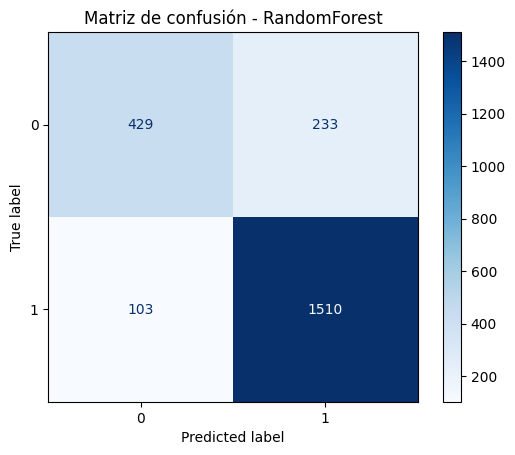

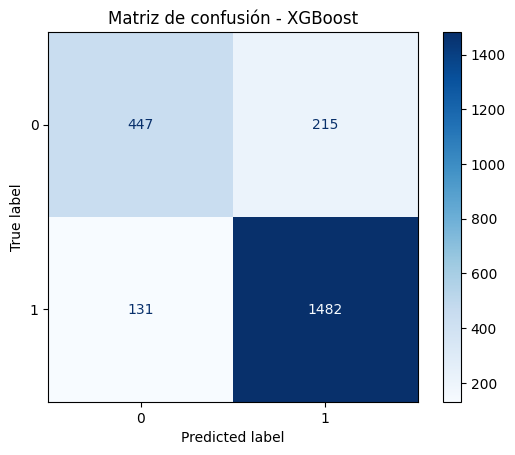

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        y_pred = model.predict(X_test_clf)
        cm = confusion_matrix(y_test_clf, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Matriz de confusión - {name}")
        plt.show()

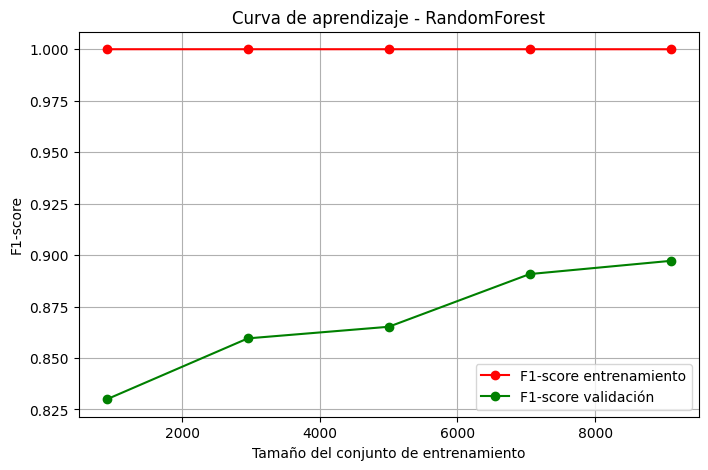

In [43]:
from sklearn.model_selection import learning_curve
import numpy as np

# Curva de aprendizaje para RandomForest
train_sizes, train_scores, test_scores = learning_curve(
    models_clf['RandomForest'], X_clf, y_clf, cv=cv, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='F1-score entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='F1-score validación')
plt.title('Curva de aprendizaje - RandomForest')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.grid()
plt.show()

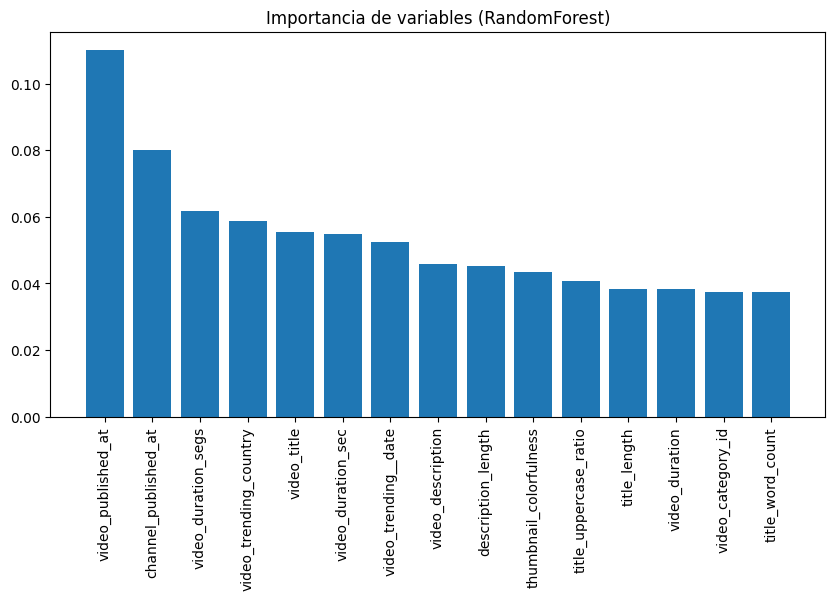

,feature,importance
0,video_published_at,0.110104
9,channel_published_at,0.079923
29,video_duration_segs,0.061774
2,video_trending_country,0.058582
3,video_title,0.055462
22,video_duration_sec,0.054743
1,video_trending__date,0.052388
4,video_description,0.045933
18,description_length,0.045201
28,thumbnail_colorfulness,0.043408


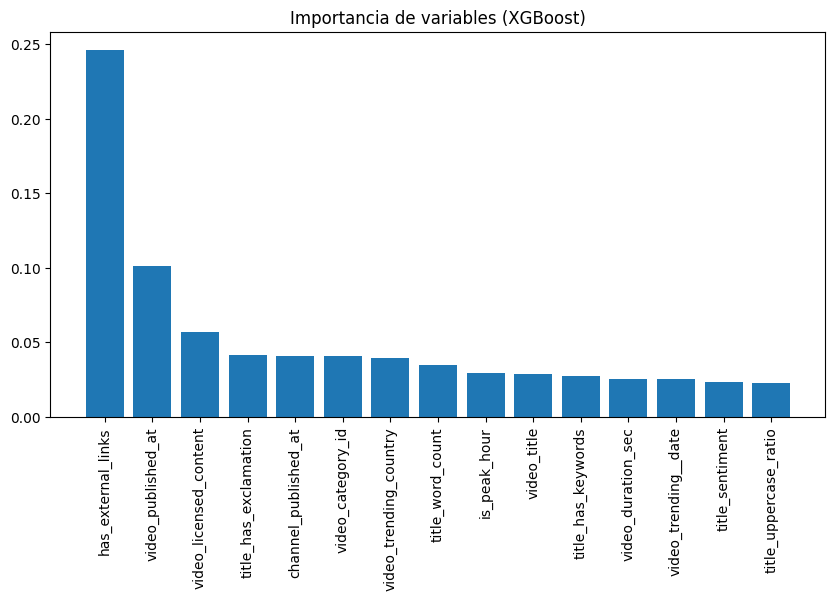

,feature,importance
20,has_external_links,0.246131
0,video_published_at,0.101023
8,video_licensed_content,0.056834
13,title_has_exclamation,0.041619
9,channel_published_at,0.040359
5,video_category_id,0.040322
2,video_trending_country,0.039164
12,title_word_count,0.034786
26,is_peak_hour,0.029262
3,video_title,0.028648


In [44]:
# Importancia de variables para RandomForest y XGBoost
import matplotlib.pyplot as plt
import pandas as pd

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        importances = model.feature_importances_
        features = X_train_clf.columns
        imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,5))
        plt.bar(imp_df['feature'][:15], imp_df['importance'][:15])
        plt.xticks(rotation=90)
        plt.title(f'Importancia de variables ({name})')
        plt.show()
        display(imp_df.head(15))

### Optimización y ajuste de modelos
En esta sección se implementan:
- Búsqueda de hiperparámetros con GridSearchCV/RandomizedSearchCV.
- Técnicas de balanceo de clases (SMOTE y class_weight).
- Ajuste del umbral de decisión para maximizar la métrica F1.

In [45]:
# Balanceo de clases con SMOTE y ajuste de class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_clf, y_train_clf)
print('Distribución de clases tras SMOTE:', Counter(y_train_bal))

# Actualizar modelos con class_weight='balanced' donde aplica
models_bal = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000)
}


Distribución de clases tras SMOTE: Counter({1: 6451, 0: 6451})


In [46]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Hiperparámetros para RandomForest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                              param_distributions=param_dist_rf, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros RandomForest:', rf_search.best_params_)

# Hiperparámetros para XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
xgb_search = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
                               param_distributions=param_dist_xgb, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
xgb_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros XGBoost:', xgb_search.best_params_)

Mejores hiperparámetros RandomForest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:04:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores hiperparámetros XGBoost: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2}


In [47]:
from sklearn.metrics import f1_score, precision_recall_curve

# Ajuste de umbral óptimo para maximizar F1-score
for name, model in zip(['RandomForest', 'XGBoost'], [rf_search.best_estimator_, xgb_search.best_estimator_]):
    model.fit(X_train_bal, y_train_bal)
    y_proba = model.predict_proba(X_test_clf)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test_clf, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"\n{name} - Mejor umbral para F1: {best_threshold:.2f} (F1={f1_scores[best_idx]:.3f})")
    y_pred_opt = (y_proba >= best_threshold).astype(int)
    print(f"Reporte clasificación con umbral óptimo:\n", classification_report(y_test_clf, y_pred_opt))


RandomForest - Mejor umbral para F1: 0.45 (F1=0.898)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

           0       0.79      0.66      0.72       662
           1       0.87      0.93      0.90      1613

    accuracy                           0.85      2275
   macro avg       0.83      0.79      0.81      2275
weighted avg       0.85      0.85      0.85      2275



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:04:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost - Mejor umbral para F1: 0.29 (F1=0.903)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

           0       0.83      0.63      0.72       662
           1       0.86      0.95      0.90      1613

    accuracy                           0.86      2275
   macro avg       0.85      0.79      0.81      2275
weighted avg       0.85      0.86      0.85      2275

